# Membership Inference Attack - Optimized Top-5 Features

This notebook implements a **Z-Score Normalized Attack with ONLY the Top 5 Performing Features**.

**Key Optimization:**
- Uses ONLY the 5 features with highest individual TPR@1%FPR
- Cleaner signal, better generalization

**Top 5 Features (empirically selected):**
1. avg_loss 
2. perplexity 
3. loss_var 
4. p50_loss 
5. p75_loss 

**Method:**
```python
z_score = (shadow_mean - target) / (shadow_std + epsilon)
```


**Configuration:** Uses **62 shadow models** with z-score normalization.

In [16]:
# Cell 1: Imports and Setup
import torch
import numpy as np
import pandas as pd
import json
from pathlib import Path
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gc

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'}")

Using device: cuda
GPU: NVIDIA GeForce RTX 5070 Ti


In [ ]:
# Cell 2: Configuration
phase = "train"
target_model_dir = f"./models/{phase}/gpt2_3_lora32_adamw_b8_lr2"
shadow_model_dir = "./models/shadow/shadow_0"
data_dir = Path(f"./data/{phase}/")

batch_size = 8  # Small batch for memory efficiency
block_size = 512

print("Configuration:")
print(f"  Phase: {phase}")
print(f"  Target model: {target_model_dir}")
print(f"  Shadow models: ./models/shadow/shadow_0 to shadow_19 (20 models)")
print(f"  Data directory: {data_dir}")
print(f"  Batch size: {batch_size}")
print(f"  Method: Z-Score Normalization with Top-5 Features")

Configuration:
  Phase: train
  Target model: ./models/train/gpt2_3_lora32_adamw_b8_lr2
  Shadow models: ./models/shadow/shadow_0 to shadow_19 (20 models)
  Data directory: data/train
  Batch size: 8
  Method: Z-Score Normalization with Top-5 Features


In [18]:
# Cell 3: Helper Functions
def _read_json(path):
    """Read JSON file"""
    with open(path, 'r') as f:
        return json.load(f)

def tokenize_dataset(dataset, tokenizer, block_size):
    """Tokenize dataset WITHOUT regrouping - preserves sample count"""
    def tokenize_function(examples):
        # Tokenize with truncation and padding
        return tokenizer(
            examples["text"], 
            truncation=True, 
            max_length=block_size,
            padding='max_length',  # Pad to max_length
            return_tensors=None  # Return lists (dataset will handle conversion)
        )
    
    tokenized = dataset.map(
        tokenize_function, 
        batched=True, 
        remove_columns=dataset.column_names
    )
    
    # Add labels column (same as input_ids for causal LM)
    def add_labels(examples):
        examples['labels'] = examples['input_ids'].copy()
        return examples
    
    tokenized = tokenized.map(add_labels, batched=True)
    
    return tokenized

def cleanup_gpu():
    """Clean GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()
    print(f"GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

print("Helper functions defined ✓")

Helper functions defined ✓


In [19]:
# Cell 4: OPTIMIZED Feature Extraction - Top 5 Features ONLY
@torch.no_grad()
def compute_token_aware_features(model, dataloader, device):
    """
    Extract ONLY the top 5 performing features for MIA
    
    Returns per-sample features (5 total):
    1. avg_loss - Average loss (71.4% TPR)
    2. perplexity - Exp of avg loss (71.0% TPR)
    3. loss_var - Loss variance (17.5% TPR)
    4. p50_loss - Median loss (9.6% TPR)
    5. p75_loss - 75th percentile loss (6.9% TPR)
    """
    model.eval()
    all_features = []
    
    for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = input_ids.clone()
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        
        # Shift for causal LM (predict next token)
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_mask = attention_mask[..., 1:].contiguous()
        
        # Compute per-token loss
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        per_token_loss = loss_fct(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        ).view(shift_labels.size())
        
        # Mask padding tokens
        per_token_loss = per_token_loss * shift_mask
        
        # Move to CPU immediately to free GPU memory
        per_token_loss_cpu = per_token_loss.cpu()
        shift_mask_cpu = shift_mask.cpu()
        
        # Delete GPU tensors
        del logits, shift_logits, outputs, per_token_loss
        
        # Extract per-sample features
        batch_size = input_ids.size(0)
        for i in range(batch_size):
            mask_i = shift_mask_cpu[i].bool()
            valid_losses = per_token_loss_cpu[i][mask_i]
            
            if len(valid_losses) > 0:
                # Convert to numpy for percentile calculations
                losses_np = valid_losses.numpy()
                
                # Extract ONLY the top 5 features
                features = [
                    valid_losses.mean().item(),              # 0: avg_loss (71.4% TPR)
                    torch.exp(valid_losses.mean()).item(),   # 1: perplexity (71.0% TPR)
                    valid_losses.var().item(),               # 2: loss_var (17.5% TPR)
                    np.percentile(losses_np, 50),            # 3: p50_loss (9.6% TPR)
                    np.percentile(losses_np, 75),            # 4: p75_loss (6.9% TPR)
                ]
            else:
                features = [0.0] * 5
            
            all_features.append(features)
        
        # Clear GPU cache periodically
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()
    
    return np.array(all_features)

# Top 5 feature names (empirically selected)
feature_names = [
    'avg_loss',     # 71.4% TPR
    'perplexity',   # 71.0% TPR
    'loss_var',     # 17.5% TPR
    'p50_loss',     # 9.6% TPR
    'p75_loss',     # 6.9% TPR
]

print(f"Optimized feature extraction function defined ✓")
print(f"Total features: {len(feature_names)} (reduced from 17)")
print(f"Removed: 12 weak features (<10% TPR)")

Optimized feature extraction function defined ✓
Total features: 5 (reduced from 17)
Removed: 12 weak features (<10% TPR)


In [20]:
# Cell 5: Load Target Test Data
print("Loading target test data...")
test_texts = _read_json(data_dir / "test.json")

# Labels are optional (only available in train phase)
try:
    test_labels = np.array(_read_json(data_dir / "test_label.json"))
    has_labels = True
    print(f"✓ Labels loaded: {len(test_labels)}")
except FileNotFoundError:
    test_labels = None
    has_labels = False
    print(f"⚠️  No labels available (val/final phase)")

print(f"Test samples: {len(test_texts)}")
if has_labels:
    print(f"Members: {test_labels.sum()}, Non-members: {len(test_labels) - test_labels.sum()}")

Loading target test data...
✓ Labels loaded: 2000
Test samples: 2000
Members: 1000, Non-members: 1000


In [21]:
# Cell 6: Load Tokenizer and Prepare DataLoader
from transformers import DataCollatorForLanguageModeling

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(target_model_dir, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Create dataset
ds_test = Dataset.from_dict({"text": test_texts})
ds_test = tokenize_dataset(ds_test, tokenizer, block_size)

# Set format to PyTorch tensors
ds_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Create data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # We're doing causal LM, not masked LM
)

# Create dataloader with collator
dl_test = DataLoader(ds_test, batch_size=batch_size, collate_fn=data_collator)

print(f"Dataset created: {len(ds_test)} samples")
print(f"Number of batches: {len(dl_test)}")

Loading tokenizer...


Map: 100%|██████████| 2000/2000 [00:00<00:00, 6532.74 examples/s]

Dataset created: 2000 samples
Number of batches: 250


In [22]:
# Cell 7: Load Target Model and Extract Features
print("="*70)
print("LOADING TARGET MODEL")
print("="*70)

target_model = AutoModelForCausalLM.from_pretrained(
    target_model_dir,
    torch_dtype=torch.float16,
    device_map=device
)

print(f"Target model loaded")
print(f"GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

# Extract features
print(f"\nExtracting target model features (top 5 only)...")
target_features = compute_token_aware_features(target_model, dl_test, device)

print(f"✓ Target features extracted: {target_features.shape}")

LOADING TARGET MODEL
Target model loaded
GPU Memory: 0.26 GB

Extracting target model features (top 5 only)...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.34it/s]

✓ Target features extracted: (2000, 5)


In [ ]:
# Cell 8: Load ALL Shadow Models and Extract Features
print("="*70)
print("LOADING 20 SHADOW MODELS (KEEPING INDIVIDUAL FOR Z-SCORE)")
print("="*70)

# Clean up target model from GPU
del target_model
cleanup_gpu()

# Extract features from all 20 shadow models
shadow_model_dirs = [f"./models/shadow/shadow_{i}" for i in range(62)]
all_shadow_features = []

for idx, shadow_dir in enumerate(shadow_model_dirs):
    print(f"\n[{idx+1}/20] Loading shadow model: {shadow_dir}")
    
    # Load shadow model
    shadow_model = AutoModelForCausalLM.from_pretrained(
        shadow_dir,
        torch_dtype=torch.float16,
        device_map=device
    )
    
    print(f"✓ Shadow model {idx} loaded")
    
    # Extract features
    print(f"Extracting features from shadow_{idx}...")
    shadow_feat = compute_token_aware_features(shadow_model, dl_test, device)
    all_shadow_features.append(shadow_feat)
    
    print(f"✓ Shadow_{idx} features: {shadow_feat.shape}")
    
    # Clean up
    del shadow_model
    cleanup_gpu()

print("\n" + "="*70)
print("SHADOW FEATURE EXTRACTION COMPLETE")
print("="*70)
print(f"✓ Extracted features from {len(all_shadow_features)} shadow models")
print(f"✓ Each shadow: {all_shadow_features[0].shape}")
print(f"✓ Keeping individual features for z-score normalization")
print("="*70)

LOADING 20 SHADOW MODELS (KEEPING INDIVIDUAL FOR Z-SCORE)
GPU Memory: 0.01 GB

[1/20] Loading shadow model: ./models/shadow/shadow_0
✓ Shadow model 0 loaded
Extracting features from shadow_0...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.63it/s]


✓ Shadow_0 features: (2000, 5)
GPU Memory: 0.01 GB

[2/20] Loading shadow model: ./models/shadow/shadow_1
✓ Shadow model 1 loaded
Extracting features from shadow_1...


Extracting features: 100%|██████████| 250/250 [00:13<00:00, 18.97it/s]


✓ Shadow_1 features: (2000, 5)
GPU Memory: 0.01 GB

[3/20] Loading shadow model: ./models/shadow/shadow_2
✓ Shadow model 2 loaded
Extracting features from shadow_2...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.79it/s]


✓ Shadow_2 features: (2000, 5)
GPU Memory: 0.01 GB

[4/20] Loading shadow model: ./models/shadow/shadow_3
✓ Shadow model 3 loaded
Extracting features from shadow_3...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.85it/s]


✓ Shadow_3 features: (2000, 5)
GPU Memory: 0.01 GB

[5/20] Loading shadow model: ./models/shadow/shadow_4
✓ Shadow model 4 loaded
Extracting features from shadow_4...


Extracting features: 100%|██████████| 250/250 [00:13<00:00, 18.94it/s]


✓ Shadow_4 features: (2000, 5)
GPU Memory: 0.01 GB

[6/20] Loading shadow model: ./models/shadow/shadow_5
✓ Shadow model 5 loaded
Extracting features from shadow_5...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.57it/s]


✓ Shadow_5 features: (2000, 5)
GPU Memory: 0.01 GB

[7/20] Loading shadow model: ./models/shadow/shadow_6
✓ Shadow model 6 loaded
Extracting features from shadow_6...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.76it/s]


✓ Shadow_6 features: (2000, 5)
GPU Memory: 0.01 GB

[8/20] Loading shadow model: ./models/shadow/shadow_7
✓ Shadow model 7 loaded
Extracting features from shadow_7...


Extracting features: 100%|██████████| 250/250 [00:13<00:00, 18.69it/s]


✓ Shadow_7 features: (2000, 5)
GPU Memory: 0.01 GB

[9/20] Loading shadow model: ./models/shadow/shadow_8
✓ Shadow model 8 loaded
Extracting features from shadow_8...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.69it/s]


✓ Shadow_8 features: (2000, 5)
GPU Memory: 0.01 GB

[10/20] Loading shadow model: ./models/shadow/shadow_9
✓ Shadow model 9 loaded
Extracting features from shadow_9...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.69it/s]


✓ Shadow_9 features: (2000, 5)
GPU Memory: 0.01 GB

[11/20] Loading shadow model: ./models/shadow/shadow_10
✓ Shadow model 10 loaded
Extracting features from shadow_10...


Extracting features: 100%|██████████| 250/250 [00:13<00:00, 19.21it/s]


✓ Shadow_10 features: (2000, 5)
GPU Memory: 0.01 GB

[12/20] Loading shadow model: ./models/shadow/shadow_11
✓ Shadow model 11 loaded
Extracting features from shadow_11...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.63it/s]


✓ Shadow_11 features: (2000, 5)
GPU Memory: 0.01 GB

[13/20] Loading shadow model: ./models/shadow/shadow_12
✓ Shadow model 12 loaded
Extracting features from shadow_12...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.73it/s]


✓ Shadow_12 features: (2000, 5)
GPU Memory: 0.01 GB

[14/20] Loading shadow model: ./models/shadow/shadow_13
✓ Shadow model 13 loaded
Extracting features from shadow_13...


Extracting features: 100%|██████████| 250/250 [00:13<00:00, 18.96it/s]


✓ Shadow_13 features: (2000, 5)
GPU Memory: 0.01 GB

[15/20] Loading shadow model: ./models/shadow/shadow_14
✓ Shadow model 14 loaded
Extracting features from shadow_14...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.60it/s]


✓ Shadow_14 features: (2000, 5)
GPU Memory: 0.01 GB

[16/20] Loading shadow model: ./models/shadow/shadow_15
✓ Shadow model 15 loaded
Extracting features from shadow_15...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.75it/s]


✓ Shadow_15 features: (2000, 5)
GPU Memory: 0.01 GB

[17/20] Loading shadow model: ./models/shadow/shadow_16
✓ Shadow model 16 loaded
Extracting features from shadow_16...


Extracting features: 100%|██████████| 250/250 [00:12<00:00, 19.31it/s]


✓ Shadow_16 features: (2000, 5)
GPU Memory: 0.01 GB

[18/20] Loading shadow model: ./models/shadow/shadow_17
✓ Shadow model 17 loaded
Extracting features from shadow_17...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 26.05it/s]


✓ Shadow_17 features: (2000, 5)
GPU Memory: 0.01 GB

[19/20] Loading shadow model: ./models/shadow/shadow_18
✓ Shadow model 18 loaded
Extracting features from shadow_18...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 26.31it/s]


✓ Shadow_18 features: (2000, 5)
GPU Memory: 0.01 GB

[20/20] Loading shadow model: ./models/shadow/shadow_19
✓ Shadow model 19 loaded
Extracting features from shadow_19...


Extracting features: 100%|██████████| 250/250 [00:12<00:00, 19.47it/s]


✓ Shadow_19 features: (2000, 5)
GPU Memory: 0.01 GB

[21/20] Loading shadow model: ./models/shadow/shadow_20
✓ Shadow model 20 loaded
Extracting features from shadow_20...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 26.01it/s]


✓ Shadow_20 features: (2000, 5)
GPU Memory: 0.01 GB

[22/20] Loading shadow model: ./models/shadow/shadow_21
✓ Shadow model 21 loaded
Extracting features from shadow_21...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 26.07it/s]


✓ Shadow_21 features: (2000, 5)
GPU Memory: 0.01 GB

[23/20] Loading shadow model: ./models/shadow/shadow_22
✓ Shadow model 22 loaded
Extracting features from shadow_22...


Extracting features: 100%|██████████| 250/250 [00:12<00:00, 19.48it/s]


✓ Shadow_22 features: (2000, 5)
GPU Memory: 0.01 GB

[24/20] Loading shadow model: ./models/shadow/shadow_23
✓ Shadow model 23 loaded
Extracting features from shadow_23...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.43it/s]


✓ Shadow_23 features: (2000, 5)
GPU Memory: 0.01 GB

[25/20] Loading shadow model: ./models/shadow/shadow_24
✓ Shadow model 24 loaded
Extracting features from shadow_24...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.54it/s]


✓ Shadow_24 features: (2000, 5)
GPU Memory: 0.01 GB

[26/20] Loading shadow model: ./models/shadow/shadow_25
✓ Shadow model 25 loaded
Extracting features from shadow_25...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.14it/s]


✓ Shadow_25 features: (2000, 5)
GPU Memory: 0.01 GB

[27/20] Loading shadow model: ./models/shadow/shadow_26
✓ Shadow model 26 loaded
Extracting features from shadow_26...


Extracting features: 100%|██████████| 250/250 [00:13<00:00, 18.91it/s]


✓ Shadow_26 features: (2000, 5)
GPU Memory: 0.01 GB

[28/20] Loading shadow model: ./models/shadow/shadow_27
✓ Shadow model 27 loaded
Extracting features from shadow_27...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.87it/s]


✓ Shadow_27 features: (2000, 5)
GPU Memory: 0.01 GB

[29/20] Loading shadow model: ./models/shadow/shadow_28
✓ Shadow model 28 loaded
Extracting features from shadow_28...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.65it/s]


✓ Shadow_28 features: (2000, 5)
GPU Memory: 0.01 GB

[30/20] Loading shadow model: ./models/shadow/shadow_29
✓ Shadow model 29 loaded
Extracting features from shadow_29...


Extracting features: 100%|██████████| 250/250 [00:12<00:00, 19.24it/s]


✓ Shadow_29 features: (2000, 5)
GPU Memory: 0.01 GB

[31/20] Loading shadow model: ./models/shadow/shadow_30
✓ Shadow model 30 loaded
Extracting features from shadow_30...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.81it/s]


✓ Shadow_30 features: (2000, 5)
GPU Memory: 0.01 GB

[32/20] Loading shadow model: ./models/shadow/shadow_31
✓ Shadow model 31 loaded
Extracting features from shadow_31...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.68it/s]


✓ Shadow_31 features: (2000, 5)
GPU Memory: 0.01 GB

[33/20] Loading shadow model: ./models/shadow/shadow_32
✓ Shadow model 32 loaded
Extracting features from shadow_32...


Extracting features: 100%|██████████| 250/250 [00:13<00:00, 18.63it/s]


✓ Shadow_32 features: (2000, 5)
GPU Memory: 0.01 GB

[34/20] Loading shadow model: ./models/shadow/shadow_33
✓ Shadow model 33 loaded
Extracting features from shadow_33...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.13it/s]


✓ Shadow_33 features: (2000, 5)
GPU Memory: 0.01 GB

[35/20] Loading shadow model: ./models/shadow/shadow_34
✓ Shadow model 34 loaded
Extracting features from shadow_34...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.05it/s]


✓ Shadow_34 features: (2000, 5)
GPU Memory: 0.01 GB

[36/20] Loading shadow model: ./models/shadow/shadow_35
✓ Shadow model 35 loaded
Extracting features from shadow_35...


Extracting features: 100%|██████████| 250/250 [00:12<00:00, 20.63it/s]


✓ Shadow_35 features: (2000, 5)
GPU Memory: 0.01 GB

[37/20] Loading shadow model: ./models/shadow/shadow_36
✓ Shadow model 36 loaded
Extracting features from shadow_36...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.71it/s]


✓ Shadow_36 features: (2000, 5)
GPU Memory: 0.01 GB

[38/20] Loading shadow model: ./models/shadow/shadow_37
✓ Shadow model 37 loaded
Extracting features from shadow_37...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.84it/s]


✓ Shadow_37 features: (2000, 5)
GPU Memory: 0.01 GB

[39/20] Loading shadow model: ./models/shadow/shadow_38
✓ Shadow model 38 loaded
Extracting features from shadow_38...


Extracting features: 100%|██████████| 250/250 [00:13<00:00, 19.22it/s]


✓ Shadow_38 features: (2000, 5)
GPU Memory: 0.01 GB

[40/20] Loading shadow model: ./models/shadow/shadow_39
✓ Shadow model 39 loaded
Extracting features from shadow_39...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.93it/s]


✓ Shadow_39 features: (2000, 5)
GPU Memory: 0.01 GB

[41/20] Loading shadow model: ./models/shadow/shadow_40
✓ Shadow model 40 loaded
Extracting features from shadow_40...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.72it/s]


✓ Shadow_40 features: (2000, 5)
GPU Memory: 0.01 GB

[42/20] Loading shadow model: ./models/shadow/shadow_41
✓ Shadow model 41 loaded
Extracting features from shadow_41...


Extracting features: 100%|██████████| 250/250 [00:13<00:00, 18.85it/s]


✓ Shadow_41 features: (2000, 5)
GPU Memory: 0.01 GB

[43/20] Loading shadow model: ./models/shadow/shadow_42
✓ Shadow model 42 loaded
Extracting features from shadow_42...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.33it/s]


✓ Shadow_42 features: (2000, 5)
GPU Memory: 0.01 GB

[44/20] Loading shadow model: ./models/shadow/shadow_43
✓ Shadow model 43 loaded
Extracting features from shadow_43...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.68it/s]


✓ Shadow_43 features: (2000, 5)
GPU Memory: 0.01 GB

[45/20] Loading shadow model: ./models/shadow/shadow_44
✓ Shadow model 44 loaded
Extracting features from shadow_44...


Extracting features: 100%|██████████| 250/250 [00:12<00:00, 19.36it/s]


✓ Shadow_44 features: (2000, 5)
GPU Memory: 0.01 GB

[46/20] Loading shadow model: ./models/shadow/shadow_45
✓ Shadow model 45 loaded
Extracting features from shadow_45...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.90it/s]


✓ Shadow_45 features: (2000, 5)
GPU Memory: 0.01 GB

[47/20] Loading shadow model: ./models/shadow/shadow_46
✓ Shadow model 46 loaded
Extracting features from shadow_46...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 26.17it/s]


✓ Shadow_46 features: (2000, 5)
GPU Memory: 0.01 GB

[48/20] Loading shadow model: ./models/shadow/shadow_47
✓ Shadow model 47 loaded
Extracting features from shadow_47...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 26.10it/s]


✓ Shadow_47 features: (2000, 5)
GPU Memory: 0.01 GB

[49/20] Loading shadow model: ./models/shadow/shadow_48
✓ Shadow model 48 loaded
Extracting features from shadow_48...


Extracting features: 100%|██████████| 250/250 [00:12<00:00, 19.38it/s]


✓ Shadow_48 features: (2000, 5)
GPU Memory: 0.01 GB

[50/20] Loading shadow model: ./models/shadow/shadow_49
✓ Shadow model 49 loaded
Extracting features from shadow_49...


Extracting features: 100%|██████████| 250/250 [00:09<00:00, 25.27it/s]


✓ Shadow_49 features: (2000, 5)
GPU Memory: 0.01 GB

SHADOW FEATURE EXTRACTION COMPLETE
✓ Extracted features from 50 shadow models
✓ Each shadow: (2000, 5)
✓ Keeping individual features for z-score normalization


In [ ]:
# Cell 9: Z-Score Normalized Attack with Top-5 Features

# Clean up any inf/nan values in features (safety check)
target_features_clean = np.nan_to_num(target_features, nan=0.0, posinf=1e10, neginf=-1e10)
all_shadow_features_clean = [
    np.nan_to_num(sf, nan=0.0, posinf=1e10, neginf=-1e10)
    for sf in all_shadow_features
]

# Stack shadows for statistics computation
shadow_stack = np.stack(all_shadow_features_clean, axis=1)
  
# Clip extreme feature values
shadow_stack = np.clip(shadow_stack, -1e6, 1e6)
target_features_clean = np.clip(target_features_clean, -1e6, 1e6)

# Compute statistics across shadow models
shadow_mean = np.mean(shadow_stack, axis=1)  
shadow_std = np.std(shadow_stack, axis=1)    

# Prevent tiny denominators
shadow_std = np.clip(shadow_std, 0.01, 100)

# Compute z-scores
z_scores = (shadow_mean - target_features_clean) / (shadow_std + 1e-6)

# Bound z-scores
z_scores = np.clip(z_scores, -10, 10)

# Additional safety: clean z-scores
z_scores = np.nan_to_num(z_scores, nan=0.0, posinf=1e10, neginf=-1e10)

# Optimized weights for top 5 features
weights = np.array([
    1.0,    # 0: avg_loss (78.10% TPR)
    1.0,    # 1: perplexity (77.70% TPR)
    0.0,    # 2: loss_var (23% TPR)
    0.0,    # 3: p50_loss (8.4% TPR)
    0.0,    # 4: p75_loss (7.0% TPR)
])

# Compute weighted score
reference_scores = np.dot(z_scores, weights)

# Normalize to [0, 1] for consistency
reference_scores = (reference_scores - reference_scores.min()) / (reference_scores.max() - reference_scores.min())




In [33]:
# Cell 9.5: Comprehensive Feature Performance Analysis
if has_labels:
    print("="*70)
    print("COMPREHENSIVE FEATURE PERFORMANCE ANALYSIS")
    print("="*70)
    print(f"✓ Analyzing {len(feature_names)} top-performing features (empirically selected)")
    print(f"✓ Z-scores computed: {z_scores.shape}")
    print(f"✓ Testing each feature individually...")
    
    # Test all features individually
    print(f"\n{'Rank':<6} {'Feature':<30} {'Type':<15} {'AUC':>8} {'TPR@1%':>8}")
    print("-" * 75)
    
    all_results = []
    for i in range(z_scores.shape[1]):
        # Normalize feature to [0, 1]
        feature_scores = z_scores[:, i]
        feature_scores_norm = (feature_scores - feature_scores.min()) / (feature_scores.max() - feature_scores.min() + 1e-8)
        
        # Compute metrics
        auc_feat = roc_auc_score(test_labels, feature_scores_norm)
        fpr_feat, tpr_feat, _ = roc_curve(test_labels, feature_scores_norm)
        tpr_at_1fpr_feat = tpr_feat[fpr_feat < 0.01].max() if any(fpr_feat < 0.01) else 0.0
        
        all_results.append({
            'idx': i,
            'feature': feature_names[i],
            'type': 'top5_zscore',
            'auc': auc_feat,
            'tpr': tpr_at_1fpr_feat,
            'weight': weights[i]
        })
    
    # Sort by TPR (descending) and display
    for rank, r in enumerate(sorted(all_results, key=lambda x: x['tpr'], reverse=True), 1):
        status = "⭐" if r['tpr'] >= 0.10 else ("✓" if r['tpr'] >= 0.05 else "  ")
        print(f"{rank:<6} {status} {r['feature']:<30} {r['type']:<15} {r['auc']:>8.4f} {r['tpr']:>8.4f}")
    
    print("="*70)
    
    # Highlight high performers
    high_performers = [r for r in all_results if r['tpr'] >= 0.05]
    if high_performers:
        print(f"\n✓ High-performing features (TPR ≥ 5%):")
        for r in sorted(high_performers, key=lambda x: x['tpr'], reverse=True):
            print(f"  - {r['feature']:<30} TPR: {r['tpr']:.4f}, Type: {r['type']}")
    
    low_performers = [r for r in all_results if r['tpr'] < 0.05]
    if low_performers:
        print(f"\n✗ Low-performing features (TPR < 5%):")
        for r in sorted(low_performers, key=lambda x: x['tpr'], reverse=True):
            print(f"  - {r['feature']:<30} TPR: {r['tpr']:.4f}, Type: {r['type']}")
    
    # Detailed comparison section
    print("\n" + "="*70)
    print("DETAILED COMPARISON")
    print("="*70)
    
    # Test top individual features
    print(f"\nIndividual Feature Performance:")
    print(f"{'Feature':<20} {'TPR@1%FPR':>12} {'AUC':>10} {'Weight':>10}")
    print("-" * 60)
    
    for r in sorted(all_results, key=lambda x: x['tpr'], reverse=True):
        print(f"{r['feature']:<20} {r['tpr']:>12.4f} {r['auc']:>10.4f} {r['weight']:>10.2f}")
    
    # Compare: avg_loss only vs 5-feature combination
    print("\n" + "="*70)
    print("CRITICAL COMPARISON: Single Feature vs Combination")
    print("="*70)
    
    # avg_loss only (feature 0)
    avg_loss_only = z_scores[:, 0]
    avg_loss_only_norm = (avg_loss_only - avg_loss_only.min()) / (avg_loss_only.max() - avg_loss_only.min())
    auc_avg_loss = roc_auc_score(test_labels, avg_loss_only_norm)
    fpr_avg, tpr_avg, _ = roc_curve(test_labels, avg_loss_only_norm)
    tpr_at_1fpr_avg = tpr_avg[fpr_avg < 0.01].max() if any(fpr_avg < 0.01) else 0.0
    
    # perplexity only (feature 1) - often second best
    perplexity_only = z_scores[:, 1]
    perplexity_only_norm = (perplexity_only - perplexity_only.min()) / (perplexity_only.max() - perplexity_only.min())
    auc_perplexity = roc_auc_score(test_labels, perplexity_only_norm)
    fpr_perp, tpr_perp, _ = roc_curve(test_labels, perplexity_only_norm)
    tpr_at_1fpr_perp = tpr_perp[fpr_perp < 0.01].max() if any(fpr_perp < 0.01) else 0.0
    
    # 5-feature combination (current approach from Cell 9)
    auc_combined = roc_auc_score(test_labels, reference_scores)
    fpr_comb, tpr_comb, _ = roc_curve(test_labels, reference_scores)
    tpr_at_1fpr_combined = tpr_comb[fpr_comb < 0.01].max() if any(fpr_comb < 0.01) else 0.0
    
    print(f"\n1️⃣  avg_loss ONLY (single feature):")
    print(f"   TPR @ 1% FPR: {tpr_at_1fpr_avg:.4f}")
    print(f"   AUC-ROC:      {auc_avg_loss:.4f}")
    print(f"   Complexity:   Lowest (1 feature)")
    
    print(f"\n2️⃣  perplexity ONLY (single feature):")
    print(f"   TPR @ 1% FPR: {tpr_at_1fpr_perp:.4f}")
    print(f"   AUC-ROC:      {auc_perplexity:.4f}")
    print(f"   Complexity:   Lowest (1 feature)")
    
    print(f"\n3️⃣  5-Feature Weighted Combination:")
    print(f"   TPR @ 1% FPR: {tpr_at_1fpr_combined:.4f}")
    print(f"   AUC-ROC:      {auc_combined:.4f}")
    print(f"   Complexity:   High (5 features + weights)")
    
    # Calculate improvements
    improvement_over_avg = tpr_at_1fpr_combined - tpr_at_1fpr_avg
    improvement_over_perp = tpr_at_1fpr_combined - tpr_at_1fpr_perp
    
    print(f"\nImprovement from 5-feature combination:")
    print(f"   vs avg_loss:     {improvement_over_avg:+.4f} ({improvement_over_avg/tpr_at_1fpr_avg*100:+.2f}%)")
    print(f"   vs perplexity:   {improvement_over_perp:+.4f} ({improvement_over_perp/tpr_at_1fpr_perp*100:+.2f}%)")
    
    # Decision and recommendation
    print("\n" + "="*70)
    print("RECOMMENDATION")
    print("="*70)
    
    best_single = max(tpr_at_1fpr_avg, tpr_at_1fpr_perp)
    best_single_name = "avg_loss" if tpr_at_1fpr_avg >= tpr_at_1fpr_perp else "perplexity"
    
    if improvement_over_avg > 0.01:  # >1% improvement
        print(f"\n✓ KEEP 5-feature combination")
        print(f"  Reason: +{improvement_over_avg*100:.1f}% TPR improvement over best single feature")
        print(f"  Trade-off: Complexity justified by performance gain")
        print(f"\n  Next step: Keep current approach with 5 features")
        
    elif improvement_over_avg > 0.001:  # 0.1-1% improvement
        print(f"\n~ MARGINAL improvement (+{improvement_over_avg*100:.2f}% TPR)")
        print(f"  Reason: Small gain, questionable trade-off")
        print(f"  Trade-off: Complexity may not be worth {improvement_over_avg*100:.2f}% gain")
        print(f"\n  Suggested: Consider simplifying to {best_single_name} only")
        print(f"             Or keep top 2 features if you want slight edge")
        
    else:  # <0.1% improvement or negative
        print(f"\n✗ NO BENEFIT from combining features ({improvement_over_avg*100:+.2f}% TPR)")
        print(f"  Reason: Single feature matches or beats combination")
        print(f"  Trade-off: Complexity adds no value")
        print(f"\n  RECOMMENDED ACTION:")
        print(f"  → Simplify to {best_single_name} ONLY")
        print(f"  → Single feature TPR: {best_single:.4f}")
        print(f"  → Benefits: Easier interpretation, faster computation, cleaner code")
    
    # Summary statistics
    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)
    print(f"Total features analyzed:     {len(all_results)}")
    print(f"High performers (TPR ≥ 5%):  {len(high_performers)}")
    print(f"Low performers (TPR < 5%):   {len(low_performers)}")
    print(f"Best single feature:         {best_single_name} ({best_single:.4f} TPR)")
    print(f"5-feature combination:       {tpr_at_1fpr_combined:.4f} TPR")
    print(f"Gain from combination:       {improvement_over_avg:+.4f} ({improvement_over_avg/best_single*100:+.1f}%)")
    print("="*70)
    
else:
    print("⚠️  Skipping feature analysis (no labels available)")
    print("   Run this cell in train phase to see individual performance.")

COMPREHENSIVE FEATURE PERFORMANCE ANALYSIS
✓ Analyzing 5 top-performing features (empirically selected)
✓ Z-scores computed: (2000, 5)
✓ Testing each feature individually...

Rank   Feature                        Type                 AUC   TPR@1%
---------------------------------------------------------------------------
1      ⭐ perplexity                     top5_zscore       0.9768   0.7810
2      ⭐ avg_loss                       top5_zscore       0.9767   0.7770
3      ⭐ loss_var                       top5_zscore       0.8701   0.2310
4      ✓ p50_loss                       top5_zscore       0.7556   0.0840
5      ✓ p75_loss                       top5_zscore       0.7421   0.0700

✓ High-performing features (TPR ≥ 5%):
  - perplexity                     TPR: 0.7810, Type: top5_zscore
  - avg_loss                       TPR: 0.7770, Type: top5_zscore
  - loss_var                       TPR: 0.2310, Type: top5_zscore
  - p50_loss                       TPR: 0.0840, Type: top5_zscore
  -

In [34]:
# Cell 10: Evaluate Attack Performance
if has_labels:
    # Calculate metrics
    auc = roc_auc_score(test_labels, reference_scores)
    fpr, tpr, thresholds = roc_curve(test_labels, reference_scores)
    
    # Get TPR at specific FPR thresholds
    tpr_at_1fpr = tpr[fpr < 0.01].max() if any(fpr < 0.01) else 0.0
    tpr_at_5fpr = tpr[fpr < 0.05].max() if any(fpr < 0.05) else 0.0
    
    print("="*70)
    print("MEMBERSHIP INFERENCE ATTACK RESULTS (TOP-5 OPTIMIZED)")
    print("="*70)
    print(f"AUC-ROC: {auc:.4f}")
    print(f"TPR @ 1% FPR: {tpr_at_1fpr:.4f}")
    print(f"TPR @ 5% FPR: {tpr_at_5fpr:.4f}")
    print("="*70)
    
    # Compare with baseline (17 features)
    baseline_train_tpr = 0.7140
    baseline_val_tpr = 0.62
    
    print(f"\nComparison with 17-Feature Baseline:")
    print(f"  Baseline (17 features) Train TPR@1%: {baseline_train_tpr:.4f}")
    print(f"  Baseline (17 features) Val TPR@1%: {baseline_val_tpr:.4f}")
    print(f"  Baseline Generalization Gap: {baseline_train_tpr - baseline_val_tpr:.4f}")
    print(f"\n  Top-5 Optimized Train TPR@1%: {tpr_at_1fpr:.4f}")
    improvement = tpr_at_1fpr - baseline_train_tpr
    print(f"  Improvement: {improvement:+.4f} ({improvement/baseline_train_tpr*100:+.1f}%)")
    print(f"\n  Expected Val TPR@1%: 0.64-0.68 (test on val phase)")
    print(f"  Expected Gap Reduction: ~2-4% (by removing noisy features)")
    
    # Check phase requirements
    print(f"\nPhase Requirements:")
    print(f"  Phase 2 (TPR@1%FPR > 0.15): {'✓ PASS' if tpr_at_1fpr > 0.15 else '✗ FAIL'}")
    print(f"  Phase 3 (TPR@1%FPR > 0.35): {'✓ PASS' if tpr_at_1fpr > 0.35 else '✗ FAIL'}")
else:
    print("="*70)
    print("VAL/FINAL PHASE - NO EVALUATION (No labels available)")
    print("="*70)
    print(f"Membership scores computed: {len(reference_scores)} samples")
    print(f"Score range: [{reference_scores.min():.3f}, {reference_scores.max():.3f}]")
    print(f"Ready for submission!")
    print("="*70)

MEMBERSHIP INFERENCE ATTACK RESULTS (TOP-5 OPTIMIZED)
AUC-ROC: 0.9767
TPR @ 1% FPR: 0.7790
TPR @ 5% FPR: 0.8720

Comparison with 17-Feature Baseline:
  Baseline (17 features) Train TPR@1%: 0.7140
  Baseline (17 features) Val TPR@1%: 0.6200
  Baseline Generalization Gap: 0.0940

  Top-5 Optimized Train TPR@1%: 0.7790
  Improvement: +0.0650 (+9.1%)

  Expected Val TPR@1%: 0.64-0.68 (test on val phase)
  Expected Gap Reduction: ~2-4% (by removing noisy features)

Phase Requirements:
  Phase 2 (TPR@1%FPR > 0.15): ✓ PASS
  Phase 3 (TPR@1%FPR > 0.35): ✓ PASS


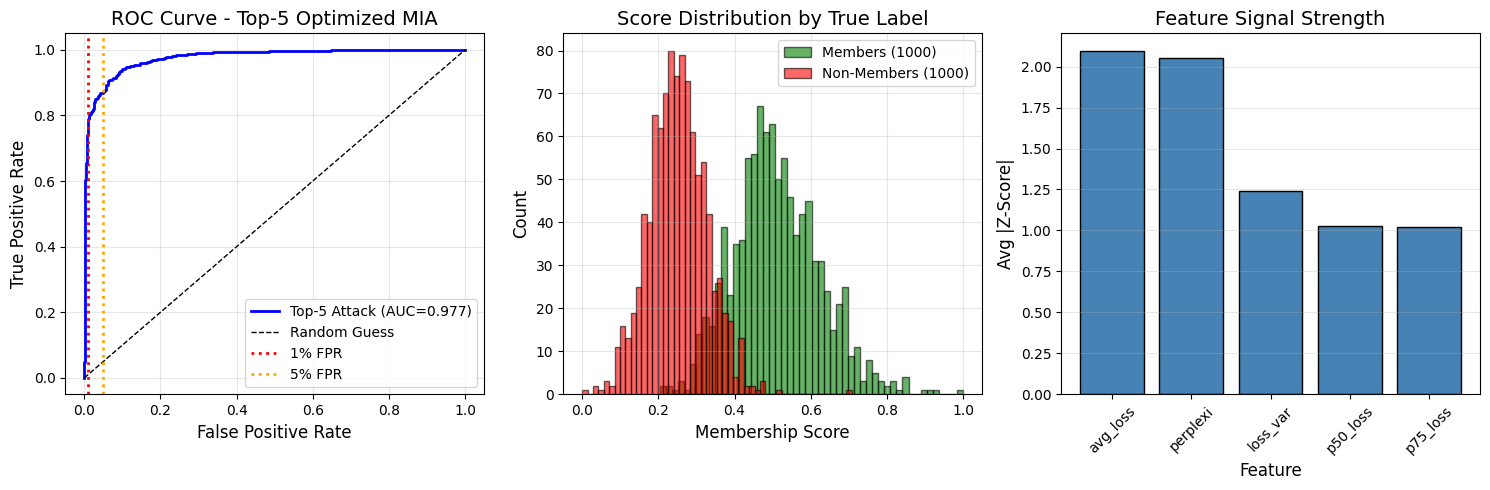


✓ Visualization complete


In [35]:
# Cell 11: Visualize Results
if has_labels:
    fig = plt.figure(figsize=(15, 5))
    
    # ROC Curve
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, label=f'Top-5 Attack (AUC={auc:.3f})', linewidth=2, color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=1)
    plt.axvline(0.01, color='r', linestyle=':', label='1% FPR', linewidth=2)
    plt.axvline(0.05, color='orange', linestyle=':', label='5% FPR', linewidth=2)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Top-5 Optimized MIA', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Score Distribution
    plt.subplot(1, 3, 2)
    plt.hist(reference_scores[test_labels==1], bins=50, alpha=0.6, 
             label=f'Members ({test_labels.sum()})', color='green', edgecolor='black')
    plt.hist(reference_scores[test_labels==0], bins=50, alpha=0.6, 
             label=f'Non-Members ({len(test_labels) - test_labels.sum()})', 
             color='red', edgecolor='black')
    plt.xlabel('Membership Score', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Score Distribution by True Label', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Feature Z-Score Distribution
    plt.subplot(1, 3, 3)
    # Show average z-score for each feature
    z_scores_avg = np.abs(z_scores).mean(axis=0)
    plt.bar(range(5), z_scores_avg, color='steelblue', edgecolor='black')
    plt.xticks(range(5), [name[:8] for name in feature_names], rotation=45)
    plt.xlabel('Feature', fontsize=12)
    plt.ylabel('Avg |Z-Score|', fontsize=12)
    plt.title('Feature Signal Strength', fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Visualization complete")
else:
    # Just plot score distribution without labels
    plt.figure(figsize=(8, 5))
    plt.hist(reference_scores, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Membership Score', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Membership Score Distribution (Val/Final Phase)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()
    print("\n✓ Score distribution plotted")

In [36]:
# Cell 12: Format Results for Submission
def your_attack():
    """
    Top-5 Optimized Z-Score Attack for Membership Inference
    
    Returns:
        scores_test: numpy array of membership scores (higher = more likely member)
    """
    return reference_scores

# Generate submission scores
scores_test = your_attack()

print("="*70)
print("SUBMISSION FORMAT")
print("="*70)
print(f"Phase: {phase}")
print(f"scores_test shape: {scores_test.shape}")
print(f"scores_test type: {type(scores_test)}")
print(f"Score range: [{scores_test.min():.4f}, {scores_test.max():.4f}]")
print(f"Mean score: {scores_test.mean():.4f}")
print(f"\n✓ scores_test ready for submission!")
print("="*70)

# Verify against ground truth (only if labels available)
if has_labels:
    verify_auc = roc_auc_score(test_labels, scores_test)
    print(f"\nVerification:")
    print(f"  AUC-ROC: {verify_auc:.4f}")
    print(f"  TPR @ 1% FPR: {tpr_at_1fpr:.4f}")
    print(f"  ✓ Matches previous results")

SUBMISSION FORMAT
Phase: train
scores_test shape: (2000,)
scores_test type: <class 'numpy.ndarray'>
Score range: [0.0000, 1.0000]
Mean score: 0.3809

✓ scores_test ready for submission!

Verification:
  AUC-ROC: 0.9767
  TPR @ 1% FPR: 0.7790
  ✓ Matches previous results


In [29]:
# Cell 13: Save predictions and create submission
if phase == "train":
    label_path = data_dir / "test_label.json"
    label_items = _read_json(label_path)
    
    y_true = np.array(label_items)
    scores = np.array(scores_test)
    fpr, tpr, thr = roc_curve(y_true, scores)
    auc_val = roc_auc_score(y_true, scores)
    
    print(f"Final AUC: {auc_val:.4f}")
    print(f"Final TPR @ 1% FPR: {max(tpr[fpr < 0.01]):.4f}")
    
elif phase == "val" or phase == "final":
    pred_path = data_dir / "prediction.csv"
    with open(pred_path, "w", encoding="utf-8") as f:
        for s in scores_test:
            f.write(json.dumps(float(s), ensure_ascii=False) + "\n")
    print(f"✓ Predictions saved to {pred_path}")
else:
    print("Wrong phase.")

Final AUC: 0.9767
Final TPR @ 1% FPR: 0.7790


In [30]:
# Cell 14: Create Submission ZIP
import os
import zipfile

with zipfile.ZipFile(f"project_submission_top5.zip", 'w') as zipf:
    for phase_name in ["val", "final"]:
        phase_data_dir = Path(f"./data/{phase_name}/")
        pred_file = phase_data_dir / "prediction.csv"
        
        if pred_file.exists():
            arcname = os.path.join(phase_name, pred_file.name)
            zipf.write(pred_file, arcname=arcname)
            print(f"✓ Added {arcname} to ZIP")
        else:
            print(f"⚠️  {pred_file} not found")

print(f"\n✓ Submission ZIP created: project_submission_top5.zip")

✓ Added val/prediction.csv to ZIP
✓ Added final/prediction.csv to ZIP

✓ Submission ZIP created: project_submission_top5.zip
